# Filtered navigable network - Step 1

This notebook test the way to create nodes and edges compatibles with OSMnx in order to be able to __use Santiago's public space quality index__ (Available in non-OSMnx road linestrings) __as a filter.__

The steps to be followed are the currently working QGIS steps:
1. Split lines with lines
2. Vector > Geometry Tools > Multipart to singleparts
3. Extract specific vertices [0,-1]
4. MMQGIS Modify > Drop dups

#### __PENDIENTE: Agregar a la working option 2 el explode de las original_lines. Ver si también salen 34,797 lineas.__

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

from shapely.geometry import GeometryCollection
from shapely.ops import split
import time

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Config notebook

In [6]:
gral_dir = '../../../data/external/santiago/'
project_name = 'redvial2019_buffer_3750m_c_utilidad_2'
p_code = '00'
public_space_quality_dir = gral_dir + f"calidad_ep/{p_code}_{project_name}/{project_name}.shp"
test_save = False

# Projection to be used whenever necessary
projected_crs = 'EPSG:32719'
# Column to filter data
filtering_column = 'pje_ep'
filtering_value = 0.5 # Will keep equal or more than this value

## Load data

In [3]:
# 1.0 --------------- LOAD DATA
# ------------------- This step loads the public space quality index gdf for the current project
# Load data
pub_space_qty = gpd.read_file(public_space_quality_dir)
# Set CRS
pub_space_qty = pub_space_qty.set_crs(projected_crs)
# Filter for data of relevance
gdf = pub_space_qty[[filtering_column,'geometry']].copy()
gdf = gdf.to_crs("EPSG:4326")

# Show
print(gdf.shape)
gdf.head(1)

(31534, 2)


,pje_ep,geometry
0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."


# Step 1 - Split lines with themselves

## Split lines with themselves (After tests, working functions performance comparison)

### Working option 1: precompute_unary_union() first, then split lines.

In [4]:
def precompute_unary_union(gdf):
    """ This function saves to a new gdf column the geometry of the unary union of the lines that intersect (sjoin) each line.
        The line itself is excluded from the unary geometry to avoid trying intersect with itself.
        The gdf keeps its original geometry, but has a new 'unary_geometry' col.
    """
    
    # Reset index in order to keep track of original line id
    lines_gdf = gdf.copy()
    lines_gdf = lines_gdf.reset_index()
    lines_gdf = lines_gdf.rename(columns={'index':'original_id'})

    # Create unary union of all lines except itself
    lines_gdf['unary_geometry'] = None

    # Create and save unary_union corresponding to each row 
    for idx, row in lines_gdf.iterrows():
        
        # rest_of_lines is lines that intersect line_of_interest (Remove itself to avoid trying to intersect with itself)
        line_of_interest = lines_gdf.loc[lines_gdf.original_id==idx].copy()
        intersecting_idxs = list(line_of_interest.sjoin(lines_gdf).original_id_right.unique())
        intersecting_idxs.remove(idx)
        rest_of_lines = lines_gdf.loc[lines_gdf.original_id.isin(intersecting_idxs)].copy().explode()

        # Save unary union
        lines_gdf.at[idx, 'unary_geometry'] = rest_of_lines.unary_union
        
    return lines_gdf


def split_line(row):
    """ This function is used with each gdf row (.apply()).
        The function splits the line geometry using the previously calculated unary_union geometry and
        returns a list of new geometries (split_lines_geoms).
    """
    
    line_geom = row['geometry']
    unary_geom = row['unary_geometry']
    
    try:
        split_result = split(line_geom, unary_geom)
        split_lines_geoms = list(split_result.geoms)
        return split_lines_geoms
    except:
        split_lines_geoms = [line_geom]
        return split_lines_geoms


def split_lines_with_themselves_v1(gdf):
    """ This splits each line using the lines that intersect it, keeping the values of all original columns.
    """
    
    # Create and save unary_union of lines intersecting each line, except itself.
    lines_gdf = precompute_unary_union(gdf)
    
    # Split the lines geometry using the previously calculated unary_union geometry.
    # Creates a list of geometries in col split_lines.
    lines_gdf = lines_gdf.explode()
    lines_gdf['split_lines'] = lines_gdf.apply(split_line, axis=1)
    
    # Explode the split lines into separate rows according to the list of geometries located in split_lines
    exploded_split_lines = lines_gdf.explode('split_lines').drop(columns=['geometry']).rename(columns={'split_lines': 'geometry'})
    
    # Create a new GeoDataFrame with the split lines
    split_lines_gdf = gpd.GeoDataFrame(exploded_split_lines, geometry='geometry', crs=lines_gdf.crs)
    
    # Drop unary_geometry col
    split_lines_gdf.drop(columns=['unary_geometry'],inplace=True)

    return split_lines_gdf

In [5]:
start = time.time()
split_lines_v1 = split_lines_with_themselves_v1(gdf)
finish = time.time()

# Show
print(f"Execution time: {finish-start}s.")
print(split_lines_v1.shape)
split_lines_v1.head(1)

Execution time: 874.5643658638s.
(34797, 3)


,,original_id,pje_ep,geometry
0,0,0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."


In [8]:
# Check result in QGIS
split_lines_v1.to_file(gral_dir + "split_lines_v1.gpkg", driver='GPKG')

### Working option 2: Find the unary_union needed while iterating over each row (line)

In [4]:
def split_lines_with_themselves_v2(lines_gdf):
    split_lines = gpd.GeoDataFrame()
    i = 0
    
    # Reset index in order to keep track of original line id
    original_lines = lines_gdf.copy()
    original_lines = original_lines.reset_index()
    original_lines = original_lines.rename(columns={'index':'original_id'})
    
    # Iterate over each line
    for idx in list(original_lines.original_id.unique()):
        start = time.time()
        
        # Find original line and its geometry
        line_of_interest = original_lines.loc[original_lines.original_id == idx]
        line_geom = line_of_interest.geometry.unique()[0]

        # Find which lines intersect line of interest (Remove itself to avoid trying to intersect with itself)
        intersecting_idxs = list(line_of_interest.sjoin(original_lines).original_id_right.unique())
        intersecting_idxs.remove(idx)
        rest_of_lines = original_lines.loc[original_lines.original_id.isin(intersecting_idxs)].copy()
        
        # Create unary union (geometry) out of the rest of the lines 
        gdf_exploded = rest_of_lines.copy().explode()
        unary_union = gdf_exploded.unary_union
        
        # Try splitting the line with the rest of the lines
        try:
            # Split geom with unary union
            split_result = split(line_geom, unary_union)
            # Extract clipped lines
            split_lines_geoms = list(split_result.geoms)
            # Register data
            for split_line_geom in split_lines_geoms:
                split_lines.loc[i,'original_id'] = line_of_interest.original_id.unique()[0]
                split_lines.loc[i,'pje_ep'] = line_of_interest.pje_ep.unique()[0]
                split_lines.loc[i,'geometry'] = split_line_geom
            
                i +=1
                
        # Except it doesn't need splitting, then just append the line
        except:
            split_lines.loc[i,'original_id'] = line_of_interest.original_id.unique()[0]
            split_lines.loc[i,'pje_ep'] = line_of_interest.pje_ep.unique()[0]
            split_lines.loc[i,'geometry'] = line_geom
            i +=1
    
    try:
        split_lines.set_crs("EPSG:4326")
    except:
        split_lines.to_crs("EPSG:4326")
    
    return split_lines

In [ ]:
start = time.time()
split_lines_v2 = split_lines_with_themselves_v2(gdf)
finish = time.time()

# Show
print(f"Execution time: {finish-start}s.")
print(split_lines_v2.shape)
split_lines_v2.head(1)

### __Working option's multilines test__ (Result: There's lack of precision due to amount of unconnected lines)

Once both working options were compared, we proceeded to Step 2 - Multipart to single parts and realized that the result contained 34,797 lines.
Using the QGIS process, the result had 34,790 lines.

#### * __Test step 1:__ The following cells explore that difference using split_lines_v2 (without exploding the lines before the process).
#### * __Result__: The resulting multilines are already exploded in the QGIS process, so those Multilines are not the cause of the aditional 7 lines.

#### * __Test step 2:__ Then we loaded the QGIS process single parts (34,790 edges) to identify those edges where the number of ID ocurrances is different. (Meaning, where lines split more that they should've).
#### * __Result:__ After multiple reviews it was concluded that the differences are due to CRS projection and badly generated network. A lot of lines were not drawn connecting to each other, but rather very very very close to them. So sometimes they intersect, sometimes not.

#### Test step 1

In [10]:
gdf_multilines = split_lines_v2[split_lines_v2.geometry.type == 'MultiLineString'].copy()
gdf_multilines

,original_id,pje_ep,geometry
233,59.0,0.569988,"MULTILINESTRING ((-70.75405 -33.47665, -70.754..."
7378,6030.0,0.208220,"MULTILINESTRING ((-70.74451 -33.48782, -70.744..."
7379,6031.0,0.378227,"MULTILINESTRING ((-70.74476 -33.48822, -70.744..."
7380,6032.0,0.503457,"MULTILINESTRING ((-70.74504 -33.48865, -70.745..."
33711,30949.0,0.304370,"MULTILINESTRING ((-70.76032 -33.45200, -70.760..."


In [11]:
# Check result in QGIS
gdf_multilines.to_file(gral_dir + "gdf_multilines.gpkg", driver='GPKG')

#### Test step 2

In [35]:
# How many unique lines/IDs there should be:
print(pub_space_qty.shape)
len(pub_space_qty.IDcllbf.unique())

(31534, 36)


31534

In [104]:
# Load QGIS processed edges (Split lines with lines + Multipart to singleparts)
qgis_processed_edges = gpd.read_file(gral_dir + f"calidad_ep/{p_code}_{project_name}/{project_name}_single_parts.gpkg" )
qgis_processed_edges = qgis_processed_edges.set_crs(projected_crs)
qgis_processed_edges = qgis_processed_edges[['IDcllbf','geometry']].copy()

# Code ID starts at 0, while qgis_id starts at 1
qgis_processed_edges['qgis_id'] = qgis_processed_edges['IDcllbf']-1

# Show
print(qgis_processed_edges.shape)
print(f"Unique IDs: {len(qgis_processed_edges.qgis_id.unique())}.")
qgis_processed_edges.head(1)

(34790, 3)
Unique IDs: 31534.


,IDcllbf,geometry,qgis_id
0,1.0,"LINESTRING (350958.903 6302268.173, 350982.496...",0.0


In [46]:
# Bring gdf to be used for the comparison
# (This split_lines_v1 resulted from working option 2, where <lines_gdf = lines_gdf.explode()> was added before applying function split_line())
# Show
print(split_lines_v1.shape)
print(f"Unique IDs: {len(split_lines_v1.original_id.unique())}.")
split_lines_v1.head(1)

(34797, 3)
Unique IDs: 31534.


,,original_id,pje_ep,geometry
0,0,0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."


In [119]:
# Count how many times each original id is located in each gdf
qgis_count = qgis_processed_edges['qgis_id'].value_counts().reset_index()
qgis_count.rename(columns={'count':'qgis_count'},inplace=True)

split_lines_count = split_lines_v1['original_id'].value_counts().reset_index()
split_lines_count.rename(columns={'count':'code_count'},inplace=True)

# Merge to compare counts
merged_count = pd.merge(qgis_count,split_lines_count,left_on='qgis_id',right_on='original_id')
merged_count['diff'] = merged_count['code_count'] - merged_count['qgis_count']
diffs = merged_count.loc[merged_count['diff']!=0]

# Show
print(diffs['diff'].sum())
diffs.loc[diffs.code_count==2]

7


,qgis_id,qgis_count,original_id,code_count,diff
83,30261.0,5,30261,2,-3
210,31018.0,3,31018,2,-1
219,31131.0,3,31131,2,-1
261,5989.0,3,5989,2,-1
263,5276.0,3,5276,2,-1
...,...,...,...,...,...
29358,9302.0,1,9302,2,1
29522,9131.0,1,9131,2,1
29523,9130.0,1,9130,2,1
31182,11401.0,1,11401,2,1


<Axes: >

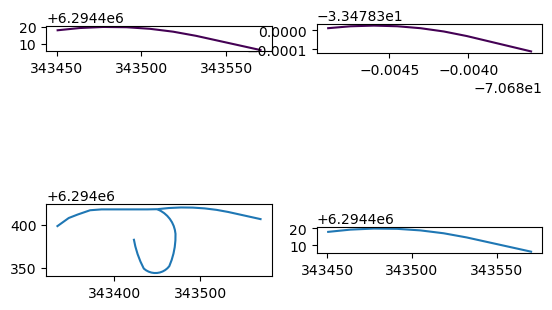

In [130]:
line_id = 9131

fig,axs=plt.subplots(2,2)

# Plot line of interest
# QGIS line
qgis_processed_edges.loc[qgis_processed_edges.qgis_id==line_id].plot('qgis_id',ax=axs[0,0])
# Code line
split_lines_v1.loc[split_lines_v1.original_id==line_id].plot('original_id',ax=axs[0,1])

# Plot what that line intersects
# QGIS intersections
qgis_intersect = qgis_processed_edges.loc[qgis_processed_edges.qgis_id==line_id].copy()
if qgis_intersect.crs != projected_crs:
    try:
        qgis_intersect = qgis_intersect.set_crs(projected_crs)
    except:
        qgis_intersect = qgis_intersect.to_crs(projected_crs)
        
intersecting = gpd.sjoin(pub_space_qty,qgis_intersect)
intersecting.plot(ax=axs[1,0])

# Code intersections
code_intersect = split_lines_v1.loc[split_lines_v1.original_id==line_id].copy()
if code_intersect.crs != projected_crs:
    try:
        code_intersect = code_intersect.set_crs(projected_crs)
    except:
        code_intersect = code_intersect.to_crs(projected_crs)
intersecting = gpd.sjoin(pub_space_qty,code_intersect)
intersecting.plot(ax=axs[1,1])

In [131]:
split_lines_v1.loc[split_lines_v1.original_id==line_id]

original_id    pje_ep   
9131 0         9131  0.920023  \
     0         9131  0.920023   

                                                 geometry  
9131 0  LINESTRING (-70.68490 -33.47829, -70.68475 -33...  
     0  LINESTRING (-70.68360 -33.47841, -70.68360 -33...

In [132]:
qgis_processed_edges.loc[qgis_processed_edges.IDcllbf==line_id+1]

,IDcllbf,geometry,qgis_id
10697,9132.0,"LINESTRING (343449.898 6294417.905, 343463.623...",9131.0


## Step 1 - How to split lines with themselves? (Tests)

### Some lines (used in tests)

In [4]:
# Tests - Isolate the first 10 lines
some_lines = gdf.loc[0:1999]

# Show
print(some_lines.shape)
some_lines.head(2)

(2000, 2)


,pje_ep,geometry
0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."
1,0.273895,"LINESTRING (-70.60036 -33.40805, -70.60032 -33..."


<Axes: >

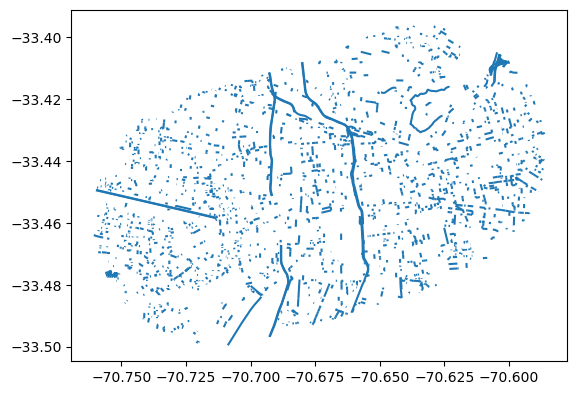

In [5]:
some_lines.plot()

### Split lines with themselves test - __[Working, 10mins aprox.]__ Intersecting each line with the unary union of the rest of the lines using .apply()

#### __Part 1:__ precompute_unary_union function

##### __Part 1 Option A__ (Memory crashes with complete gdf, option B is faster and lighter)

* 2000 lines result: 41.16s, 144,144 bytes.
* Complete gdf result: Memory crash

In [30]:
def precompute_unary_union(gdf):
    
    # Reset index in order to keep track of original line id
    lines_gdf = gdf.copy()
    lines_gdf = lines_gdf.reset_index()
    lines_gdf = lines_gdf.rename(columns={'index':'original_id'})

    # Create unary union of all lines except itself
    lines_gdf['unary_geometry'] = None
    
    unary_sum_time = 0
    
    for idx, row in lines_gdf.iterrows():
        
        start = time.time()

        # Option A: rest_of_lines is all lines except itself
        rest_of_lines = lines_gdf.drop(idx).copy().explode()
        
        # Option B: rest_of_lines is lines that intersect line_of_interest (Remove itself to avoid trying to intersect with itself)
        #line_of_interest = lines_gdf.loc[lines_gdf.original_id==idx].copy()
        #intersecting_idxs = list(line_of_interest.sjoin(lines_gdf).original_id_right.unique())
        #intersecting_idxs.remove(idx)
        #rest_of_lines = lines_gdf.loc[lines_gdf.original_id.isin(intersecting_idxs)].copy().explode()

        # Save unary union
        lines_gdf.at[idx, 'unary_geometry'] = rest_of_lines.unary_union

        unary_time = time.time()
        unary_extent = unary_time - start
        unary_sum_time = unary_sum_time + unary_extent

    print(unary_sum_time)
        
    return lines_gdf

option_a = precompute_unary_union(some_lines)

# Show
print(option_a.shape)
print(sys.getsizeof(option_a))
option_a

41.16363716125488
(2000, 4)
144144


,original_id,pje_ep,geometry,unary_geometry
0,0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33...",MULTILINESTRING ((-70.60035990020656 -33.40804...
1,1,0.273895,"LINESTRING (-70.60036 -33.40805, -70.60032 -33...",MULTILINESTRING ((-70.6028043226681 -33.408581...
2,2,0.335099,"LINESTRING (-70.60215 -33.40975, -70.60207 -33...",MULTILINESTRING ((-70.6028043226681 -33.408581...
3,3,0.106013,"LINESTRING (-70.60215 -33.40975, -70.60213 -33...",MULTILINESTRING ((-70.6028043226681 -33.408581...
4,4,0.019630,"LINESTRING (-70.60426 -33.40751, -70.60418 -33...",MULTILINESTRING ((-70.6028043226681 -33.408581...
...,...,...,...,...
1995,1995,0.398871,"LINESTRING (-70.71241 -33.47566, -70.71233 -33...",MULTILINESTRING ((-70.6028043226681 -33.408581...
1996,1996,0.759022,"LINESTRING (-70.59714 -33.44613, -70.59707 -33...",MULTILINESTRING ((-70.6028043226681 -33.408581...
1997,1997,0.542557,"LINESTRING (-70.61383 -33.44717, -70.61389 -33...",MULTILINESTRING ((-70.6028043226681 -33.408581...
1998,1998,0.882666,"LINESTRING (-70.58764 -33.44384, -70.58863 -33...",MULTILINESTRING ((-70.6028043226681 -33.408581...


##### __Part 1 Option B__

* 2000 lines result: 29.17s, 114,672 bytes.
* Complete gdf result: 595.57s (9.92min), 2,268,720 bytes (2.27Mb)

In [ ]:
def precompute_unary_union(gdf):
    
    # Reset index in order to keep track of original line id
    lines_gdf = gdf.copy()
    lines_gdf = lines_gdf.reset_index()
    lines_gdf = lines_gdf.rename(columns={'index':'original_id'})

    # Create unary union of all lines except itself
    lines_gdf['unary_geometry'] = None
    
    unary_sum_time = 0
    
    for idx, row in lines_gdf.iterrows():
        
        start = time.time()

        # Option A: rest_of_lines is all lines except itself
        #rest_of_lines = lines_gdf.drop(idx).copy().explode()
        
        # Option B: rest_of_lines is lines that intersect line_of_interest (Remove itself to avoid trying to intersect with itself)
        line_of_interest = lines_gdf.loc[lines_gdf.original_id==idx].copy()
        intersecting_idxs = list(line_of_interest.sjoin(lines_gdf).original_id_right.unique())
        intersecting_idxs.remove(idx)
        rest_of_lines = lines_gdf.loc[lines_gdf.original_id.isin(intersecting_idxs)].copy().explode()

        # Save unary union
        lines_gdf.at[idx, 'unary_geometry'] = rest_of_lines.unary_union

        unary_time = time.time()
        unary_extent = unary_time - start
        unary_sum_time = unary_sum_time + unary_extent

    print(unary_sum_time)
        
    return lines_gdf

option_b = precompute_unary_union(gdf)

# Show
print(option_b.shape)
print(sys.getsizeof(option_b))
option_b

#### __Part 2__

Input: Part 1 Option b

In [ ]:
# Show
print(option_b.shape)
option_b.head(1)

In [98]:
lines_gdf = option_b.copy()
def split_line(row):
    line_geom = row['geometry']
    unary_geom = row['unary_geometry']
    
    try:
        split_result = split(line_geom, unary_geom)
        split_lines_geoms = list(split_result.geoms)
        return split_lines_geoms
    except:
        split_lines_geoms = [line_geom]
        return split_lines_geoms

# Apply the split operation using .apply()
lines_gdf['split_lines'] = lines_gdf.apply(split_line, axis=1)

# Explode the split lines into separate rows according to the list of geometries located in split_lines
exploded_split_lines = lines_gdf.explode('split_lines').drop(columns=['geometry']).rename(columns={'split_lines': 'geometry'})

# Create a new GeoDataFrame with the split lines
split_lines_gdf = gpd.GeoDataFrame(exploded_split_lines, geometry='geometry', crs=lines_gdf.crs)

# Drop unary_geometry col
split_lines_gdf.drop(columns=['unary_geometry'],inplace=True)

# Show
print(split_lines_gdf.shape)
split_lines_gdf.head(1)

(34790, 3)


,original_id,pje_ep,geometry
0,0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."


### Split lines with themselves test - __[Working, 10 mins aprox.]__ Intersecting each line with the unary union of the rest of the lines

#### __Option A:__ Unary union of all lines except line_of_interest

* 2000 lines result: 40.53s unary union, 4.00s saving split lines.
* Complete gdf result: Manually stopped after 1hr.

In [32]:
def split_lines_with_themselves(lines_gdf):
    split_lines = gpd.GeoDataFrame()
    i = 0
    
    # Reset index in order to keep track of original line id
    original_lines = lines_gdf.copy()
    original_lines = original_lines.reset_index()
    original_lines = original_lines.rename(columns={'index':'original_id'})

    unary_sum_time = 0
    split_sum_time = 0
    
    # Iterate over each line
    for idx in list(original_lines.original_id.unique()):
        start = time.time()
        
        # Find original line and its geometry
        line_of_interest = original_lines.loc[original_lines.original_id == idx]
        line_geom = line_of_interest.geometry.unique()[0]
        # Create unary union (geometry) out of the rest of the lines (Avoids trying to intersect with itself)
        rest_of_lines = original_lines.loc[original_lines.original_id != idx]
        gdf_exploded = rest_of_lines.copy().explode()
        unary_union = gdf_exploded.unary_union

        unary_time = time.time()
        unary_extent = unary_time - start
        
        # Try splitting the line with the rest of the lines
        try:
            # Split geom with unary union
            split_result = split(line_geom, unary_union)
            # Extract clipped lines
            split_lines_geoms = list(split_result.geoms)
            # Register data
            for split_line_geom in split_lines_geoms:
                split_lines.loc[i,'original_id'] = line_of_interest.original_id.unique()[0]
                split_lines.loc[i,'pje_ep'] = line_of_interest.pje_ep.unique()[0]
                split_lines.loc[i,'geometry'] = split_line_geom
            
                i +=1
                
        # Except it doesn't need splitting, then just append the line
        except:
            split_lines.loc[i,'original_id'] = line_of_interest.original_id.unique()[0]
            split_lines.loc[i,'pje_ep'] = line_of_interest.pje_ep.unique()[0]
            split_lines.loc[i,'geometry'] = line_geom
            i +=1

        split_time = time.time()
        split_extent = split_time - unary_time

        unary_sum_time = unary_sum_time + unary_extent
        split_sum_time = split_sum_time + split_extent
            
        #print(f"unary_time {idx}: {unary_time - start}")
        #print(f"split_time {idx}: {split_time - unary_time}")
        
    print(f"unary_time {unary_sum_time}")
    print(f"split_time {split_sum_time}")
    
    try:
        split_lines.set_crs("EPSG:4326")
    except:
        split_lines.to_crs("EPSG:4326")
    
    return split_lines

In [88]:
# split_lines_with_themselves time test
split_lines = split_lines_with_themselves(some_lines)

# Show
print(split_lines.shape)
split_lines.head(2)

unary_time 0.06010150909423828
split_time 0.02144789695739746
(15, 3)


,original_id,pje_ep,geometry
0,0.0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."
1,1.0,0.273895,"LINESTRING (-70.60036 -33.40805, -70.60032 -33..."


In [89]:
split_lines

,original_id,pje_ep,geometry
0,0.0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."
1,1.0,0.273895,"LINESTRING (-70.60036 -33.40805, -70.60032 -33..."
2,2.0,0.335099,"LINESTRING (-70.60215 -33.40975, -70.60207 -33..."
3,3.0,0.106013,"LINESTRING (-70.60215 -33.40975, -70.60213 -33..."
4,4.0,0.019630,"LINESTRING (-70.60426 -33.40751, -70.60418 -33..."
5,5.0,0.010179,"LINESTRING (-70.60344 -33.40561, -70.60346 -33..."
6,5.0,0.010179,"LINESTRING (-70.60444 -33.40834, -70.60452 -33..."
7,6.0,0.549756,"LINESTRING (-70.60322 -33.40575, -70.60328 -33..."
8,7.0,0.981766,"LINESTRING (-70.60410 -33.40828, -70.60396 -33..."
9,7.0,0.981766,"LINESTRING (-70.60183 -33.40779, -70.60181 -33..."


#### __Option B:__ Unary union of lines intersect line_of_interest only

* 2000 lines result: 27.83s unary union, 2.05s saving split lines.
* Full gdf result: 549.47s (9.16min) unary union, 63.68s saving split lines.

In [34]:
def split_lines_with_themselves_v2(lines_gdf):
    split_lines = gpd.GeoDataFrame()
    i = 0
    
    # Reset index in order to keep track of original line id
    original_lines = lines_gdf.copy()
    original_lines = original_lines.reset_index()
    original_lines = original_lines.rename(columns={'index':'original_id'})

    unary_sum_time = 0
    split_sum_time = 0
    
    # Iterate over each line
    for idx in list(original_lines.original_id.unique()):
        start = time.time()
        
        # Find original line and its geometry
        line_of_interest = original_lines.loc[original_lines.original_id == idx]
        line_geom = line_of_interest.geometry.unique()[0]

        # Find which lines intersect line of interest (Remove itself to avoid trying to intersect with itself)
        intersecting_idxs = list(line_of_interest.sjoin(original_lines).original_id_right.unique())
        intersecting_idxs.remove(idx)
        rest_of_lines = original_lines.loc[original_lines.original_id.isin(intersecting_idxs)].copy()
        
        # Create unary union (geometry) out of the rest of the lines 
        gdf_exploded = rest_of_lines.copy().explode()
        unary_union = gdf_exploded.unary_union

        unary_time = time.time()
        unary_extent = unary_time - start
        
        # Try splitting the line with the rest of the lines
        try:
            # Split geom with unary union
            split_result = split(line_geom, unary_union)
            # Extract clipped lines
            split_lines_geoms = list(split_result.geoms)
            # Register data
            for split_line_geom in split_lines_geoms:
                split_lines.loc[i,'original_id'] = line_of_interest.original_id.unique()[0]
                split_lines.loc[i,'pje_ep'] = line_of_interest.pje_ep.unique()[0]
                split_lines.loc[i,'geometry'] = split_line_geom
            
                i +=1
                
        # Except it doesn't need splitting, then just append the line
        except:
            split_lines.loc[i,'original_id'] = line_of_interest.original_id.unique()[0]
            split_lines.loc[i,'pje_ep'] = line_of_interest.pje_ep.unique()[0]
            split_lines.loc[i,'geometry'] = line_geom
            i +=1

        split_time = time.time()
        split_extent = split_time - unary_time

        unary_sum_time = unary_sum_time + unary_extent
        split_sum_time = split_sum_time + split_extent
        
    print(f"unary_time {unary_sum_time}")
    print(f"split_time {split_sum_time}")
    
    try:
        split_lines.set_crs("EPSG:4326")
    except:
        split_lines.to_crs("EPSG:4326")
    
    return split_lines

In [37]:
# split_lines_with_themselves_v2 time test
split_lines = split_lines_with_themselves_v2(gdf)

# Show
print(split_lines.shape)
split_lines.head(2)

unary_time 549.4746608734131
split_time 63.688814878463745
(31534, 3)


,original_id,pje_ep,geometry
0,0.0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."
1,1.0,0.273895,"LINESTRING (-70.60036 -33.40805, -70.60032 -33..."


In [12]:
# Check result in QGIS
#some_lines.to_file(gral_dir + "some_lines.gpkg", driver='GPKG')
#split_lines.to_file(gral_dir + "split_lines.gpkg", driver='GPKG')

### Split lines with themselves test - __[NOT WORKING]__ Sjoining each line with the rest to identify which lines cross with with that line.

In [94]:
def split_lines_with_themselves(lines_gdf):

    original_lines = lines_gdf.copy()
    original_lines.reset_index(inplace=True)
    original_lines = original_lines.rename(columns={'index':'original_id'})

    idx_lst = [0,1,2,3,4,5,6,7,8] #list(original_lines.original_id.unique())

    # Find which lines intersect with which lines
    sjoined = original_lines.sjoin(original_lines)
    
    split_lines_list = []
    for idx in idx_lst:
        # Locate line of interest
        line_of_interest = original_lines.loc[original_lines.original_id==idx]
        # Locate which lines intersect that line of interest (Drop itself)
        sjoined_line = sjoined.loc[sjoined.original_id_left==idx]
        intersecting_lines_ids = list(sjoined_line.original_id_right.unique())
        intersecting_lines_ids.remove(idx)
        intersecting_lines = original_lines.loc[original_lines.original_id.isin(intersecting_lines_ids)]

        # Geometry of line of interest
        line_to_split = line_of_interest.geometry
        # Iterate over each intersecting lines geometry
        for splitter in intersecting_lines.geometry:
        
    return line_of_interest, intersecting_lines

line_of_interest, intersecting_lines = split_lines_with_themselves(some_lines)

### Split lines with themselves test - __[NOT WORKING]__ Stack overflow Help

In [28]:
# SOURCE: https://gis.stackexchange.com/questions/447677/geopandas-split-intersecting-linestrings-and-keep-columns

In [7]:
# Show clipped (10 lines) data
print(some_lines.shape)
some_lines.head(2)

(10, 2)


,pje_ep,geometry
0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."
1,0.273895,"LINESTRING (-70.60036 -33.40805, -70.60032 -33..."


#### Original Stack overflow code

In [19]:
# split ways
unary = some_lines.geometry.unary_union
geometries = [i for i in unary]
ids = [j for j in range(len(geometries))]
unary = gpd.GeoDataFrame({"id": ids, "geometry": geometries}, crs="EPSG:4326")
results = [] #empty list to store the results
for i in range(len(unary)):
    joined = gpd.sjoin(unary.loc[[i]], some_lines, how="inner", op='within')
    results.append(joined)
joined = pd.concat(results)

# Show
print(joined.shape)
joined.head(1)

TypeError: 'MultiLineString' object is not iterable

#### Exploding before iterating

In [20]:
gdf_exploded = some_lines.copy().explode()
gdf_exploded.geom_type.unique()

array(['LineString'], dtype=object)

In [21]:
# split ways
unary = gdf_exploded.geometry.unary_union
geometries = [i for i in unary]
ids = [j for j in range(len(geometries))]
unary = gpd.GeoDataFrame({"id": ids, "geometry": geometries}, crs="EPSG:4326")
results = [] #empty list to store the results
for i in range(len(unary)):
    joined = gpd.sjoin(unary.loc[[i]], gdf_exploded, how="inner", op='within')
    results.append(joined)
joined = pd.concat(results)

# Show
print(joined.shape)
joined.head(1)

TypeError: 'MultiLineString' object is not iterable

#### Adding .geoms to original stack overflow code

In [25]:
# split ways
unary = some_lines.geometry.unary_union
geometries = [i for i in unary.geoms]
ids = [j for j in range(len(geometries))]
print(len(ids))
unary = gpd.GeoDataFrame({"id": ids, "geometry": geometries}, crs="EPSG:4326")
results = [] #empty list to store the results
for i in range(len(unary)):
    joined = gpd.sjoin(unary.loc[[i]], some_lines, how="inner", op='within')
    results.append(joined)
joined = pd.concat(results)

# Show
print(joined.shape)
joined

15
(7, 4)


,id,geometry,index_right,pje_ep
0,0,"LINESTRING (-70.60280 -33.40858, -70.60255 -33...",0,0.209171
1,1,"LINESTRING (-70.60036 -33.40805, -70.60032 -33...",1,0.273895
2,2,"LINESTRING (-70.60215 -33.40975, -70.60207 -33...",2,0.335099
3,3,"LINESTRING (-70.60215 -33.40975, -70.60213 -33...",3,0.106013
4,4,"LINESTRING (-70.60426 -33.40751, -70.60418 -33...",4,0.019630
7,7,"LINESTRING (-70.60322 -33.40575, -70.60328 -33...",6,0.549756
12,12,"LINESTRING (-70.60036 -33.40805, -70.60022 -33...",8,0.282520


<Axes: >

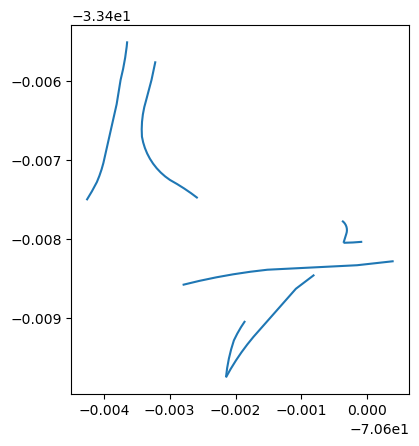

In [26]:
joined.plot()

### Split lines with themselves test - __[NOT WORKING]__ ChatGPT suggested splitting each line with another line (splitter, except itself)

In [113]:
from shapely.geometry import LineString, MultiLineString
from shapely.ops import split

In [15]:
def split_lines_with_themselves(lines_gdf):
    # Ensure geometries are valid
    lines_gdf = lines_gdf[lines_gdf.is_valid]

    split_lines_list = []

    for idx, line in lines_gdf.iterrows():
        line_to_split = line.geometry  # Initialize the line to be split
        for splitter in lines_gdf.geometry:
            if line_to_split != splitter:  # Avoid splitting a line with itself
                try:
                    # Perform the split
                    split_result = split(line_to_split, splitter)
                    # Ensure that split_result has elements
                    if split_result:
                        split_line = MultiLineString([geom for geom in split_result])
                        
                        # Append the resulting split lines to the list inside the loop
                        if isinstance(split_line, MultiLineString):
                            split_lines_list.extend(split_line.geoms)  # Use .geoms to iterate over the LineStrings in the MultiLineString
                        else:
                            split_lines_list.append(split_line)
                except:
                    continue
    
    # Create a new GeoDataFrame with the split lines
    split_lines_gdf = gpd.GeoDataFrame(geometry=split_lines_list, crs=lines_gdf.crs)
    
    return split_lines_gdf

# Perform split_lines_with_themselves
#lines_gdf = gdf.copy()
#split_lines_gdf = split_lines_with_themselves(lines_gdf)

# Show
#print(split_lines_gdf.shape)
#split_lines_gdf.head(1)

# Step 2 - Multipart to singleparts

In [139]:
split_lines_singleparts = split_lines_v1.explode()

# Show
print(split_lines_singleparts.shape)
split_lines_singleparts.head(1)

(34797, 3)


,,,original_id,pje_ep,geometry
0,0,0,0,0.209171,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."


In [ ]:
split_lines_singleparts = split_lines_v2.explode()

# Show
print(split_lines_singleparts.shape)
split_lines_singleparts.head(1)

# Step 3 - Extract specific vertices [0,-1]

### Current working code (Extracts all vertices, not starting and ending point)

In [145]:
# Reset index
lines_gdf = split_lines_singleparts.droplevel(1)
lines_gdf.reset_index(inplace=True)
lines_gdf.drop(columns=['index'],inplace=True)

#Initialize an empty list to store the points
points = []
attributes = []

#Iterate through each LineString and extract its vertices
for idx, row in lines_gdf.iterrows():
    line = row.geometry
    for coord in line.coords:
        points.append(Point(coord))
        attributes.append(row.pje_ep)

# Create a new GeoDataFrame from the points
gdf_points = gpd.GeoDataFrame(attributes,geometry=points)

# Rename data
gdf_points.rename(columns={0:'pje_ep'},inplace=True)

# Show
print(gdf_points.shape)
gdf_points.head(1)

(102063, 2)


,pje_ep,geometry
0,0.209171,POINT (-70.60280 -33.40858)


In [146]:
# Check result in QGIS
gdf_points.to_file(gral_dir + "gdf_points.gpkg", driver='GPKG')

### Lines and points coords exploration

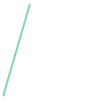

In [147]:
line

In [152]:
for coord in line.coords:
    print(coord)

(-70.65005436730556, -33.48618837942626)
(-70.6500520390151, -33.48616515340481)
(-70.64985585209362, -33.485489927598245)


In [160]:
coords = line.coords
num_points = len(line.coords)

starting_coord = coords[0]
ending_coord = coords[num_points-1]

print(starting_coord)
print(ending_coord)

(-70.65005436730556, -33.48618837942626)
(-70.64985585209362, -33.485489927598245)


### Desired result: Save starting and ending coord only

In [7]:
# Reset index
lines_gdf = split_lines_singleparts.droplevel(1)
lines_gdf.reset_index(inplace=True)
lines_gdf.drop(columns=['index'],inplace=True)

#Initialize an empty list to store the points
points = []
attributes = []

#Iterate through each LineString and extract its vertices
for idx, row in lines_gdf.iterrows():

    # Identify line, its coordinates and how many there are
    line = row.geometry
    line_coords = line.coords
    num_points = len(line_coords)

    # Save starting coord
    starting_coord = line_coords[0]
    points.append(Point(starting_coord))
    attributes.append(row.pje_ep)

    # Save ending coord
    ending_coord = line_coords[num_points-1]
    points.append(Point(ending_coord))
    attributes.append(row.pje_ep)
        
# Create a new GeoDataFrame from the points
gdf_points_2 = gpd.GeoDataFrame(attributes,geometry=points)

# Rename data
gdf_points_2.rename(columns={0:'pje_ep'},inplace=True)

# Show
print(gdf_points_2.shape)
gdf_points_2.head(1)

(69594, 2)


,pje_ep,geometry
0,0.209171,POINT (-70.60280 -33.40858)


In [163]:
# Check result in QGIS
gdf_points_2.to_file(gral_dir + "gdf_points_2.gpkg", driver='GPKG')

# Step 4 - Drop duplicates

#### __Result:__ Less nodes than expected (24,174 vs 25.126 QGIS processing)
#### __Reason:__ Nodes from QGIS are located very close to other nodes. Badly formed.

In [4]:
gdf_points_2 = gpd.read_file(gral_dir + "gdf_points_2.gpkg")

# Show
print(gdf_points_2.shape)
gdf_points_2.head(1)

(69594, 2)


,pje_ep,geometry
0,0.209171,POINT (-70.60280 -33.40858)


In [5]:
points_dropped = gdf_points_2.drop_duplicates(subset='geometry')
# Show
print(points_dropped.shape)
points_dropped.head(1)

(24174, 2)


,pje_ep,geometry
0,0.209171,POINT (-70.60280 -33.40858)


In [7]:
if test_save:
    # Check result in QGIS
    points_dropped.to_file(gral_dir + "points_dropped.gpkg", driver='GPKG')

#### Examine points dropped data (Looking for nodes that were generated too close from one another, not connecting, not dropped.)

In [11]:
# Create 1 meter buffer around nodes
points_dropped = points_dropped.to_crs(projected_crs)
points_buffer = points_dropped.buffer(1).reset_index().rename(columns={0: "geometry"})
points_buffer = points_buffer.set_geometry("geometry")

# Intersect nodes with that buffer
nodes_buffer_intersect = gpd.sjoin(points_buffer,points_dropped)

# Count number of ocurrances in each buffer, each buffer should have 1 node
nodes_buffer_count = nodes_buffer_intersect['index'].value_counts().reset_index()
close_nodes = nodes_buffer_count.loc[nodes_buffer_count['count']>1]

print(f"Number of nodes at a 1 meter distance to other nodes: {close_nodes['count'].sum()-len(close_nodes)}.")
close_nodes

Number of nodes at a 1 meter distance to other nodes: 2040.


,index,count
0,947,6
1,22743,6
2,14115,5
3,19289,5
4,24141,5
...,...,...
1698,870,2
1699,15517,2
1700,67897,2
1701,65918,2


#### Examine QGIS processed nodes data (Looking for nodes that were generated too close from one another, not connecting, not dropped.)

In [13]:
# Load QGIS processed edges (Split lines with lines + Multipart to singleparts)
qgis_processed_nodes = gpd.read_file(gral_dir + f"calidad_ep/{p_code}_{project_name}/{project_name}_nodes.shp" )
# Show
print(qgis_processed_nodes.shape)
qgis_processed_nodes.head(1)

(25126, 43)


,fid,IDcllbf,shp_lng,st_lng_,Nom_Rut,Rol_Mop,Clas_Rt,Tip_Crp,Catego,Cod_Rgn,...,pje_ep,UV,buffer800,vertex_pos,vertex_ind,vertex_par,vertex_p_1,distance,angle,geometry
0,1.0,1.0,0.0,1813.857525,Túnel Kennedy,None,5,None,Urbano,13,...,0.209171,0,0.0,0,0,0,0,0.0,75.686533,POINT (350958.903 6302268.173)


In [14]:
qgis_points_dropped = qgis_processed_nodes.drop_duplicates(subset='geometry')
# Show
print(qgis_points_dropped.shape)
qgis_points_dropped.head(1)

(25126, 43)


,fid,IDcllbf,shp_lng,st_lng_,Nom_Rut,Rol_Mop,Clas_Rt,Tip_Crp,Catego,Cod_Rgn,...,pje_ep,UV,buffer800,vertex_pos,vertex_ind,vertex_par,vertex_p_1,distance,angle,geometry
0,1.0,1.0,0.0,1813.857525,Túnel Kennedy,None,5,None,Urbano,13,...,0.209171,0,0.0,0,0,0,0,0.0,75.686533,POINT (350958.903 6302268.173)


In [15]:
# Create 1 meter buffer around nodes
points_buffer = qgis_points_dropped.buffer(1).reset_index().rename(columns={0: "geometry"})
points_buffer = points_buffer.set_geometry("geometry")

# Intersect nodes with that buffer
nodes_buffer_intersect = gpd.sjoin(points_buffer,qgis_points_dropped)

# Count number of ocurrances in each buffer, each buffer should have 1 node
nodes_buffer_count = nodes_buffer_intersect['index'].value_counts().reset_index()
close_nodes = nodes_buffer_count.loc[nodes_buffer_count['count']>1]

print(f"Number of nodes at a 1 meter distance to other nodes: {close_nodes['count'].sum()-len(close_nodes)}.")
close_nodes

Number of nodes at a 1 meter distance to other nodes: 5100.


,index,count
0,11136,7
1,24221,7
2,11138,7
3,9724,7
4,9723,7
...,...,...
3104,7221,2
3105,7670,2
3106,23182,2
3107,24263,2


# Snapping test [fail]

In [37]:
IDs_list = [30985,30984,30975,30972,30976,30978,30971,30987,30262,15651]
qgis_snapping_test = pub_space_qty.loc[pub_space_qty.IDcllbf.isin(IDs_list)]
#qgis_snapping_test = qgis_snapping_test.to_crs(projected_crs)

# Show
print(qgis_snapping_test.shape)
qgis_snapping_test

(10, 36)


,IDcllbf,shp_lng,st_lng_,Nom_Rut,Rol_Mop,Clas_Rt,Tip_Crp,Catego,Cod_Rgn,id,...,nr_trtr,ndvi_mn,ndvi_md,es_cll_,utilidd,rank_tl,pje_ep,UV,buffer800,geometry
15650,15651.0,73.173546,73.173546,La Niña,None,9,None,Urbano,13,1.0,...,0.0,0.091791,0.086393,0.0,0.018260,3312.0,0.105029,0,0,"LINESTRING (336580.701 6296168.053, 336593.202..."
30261,30262.0,229.994797,229.994797,Austral,None,9,None,Urbano,13,1.0,...,0.0,0.122744,0.116526,0.0,0.331053,11789.0,0.373850,0,0,"LINESTRING (336369.749 6296328.592, 336438.898..."
30970,30971.0,158.968251,157.585462,Isla Hope,None,9,None,Urbano,13,1.0,...,0.0,0.050969,0.048876,0.0,-0.392326,628.0,0.019915,0,0,"LINESTRING (336558.760 6296293.203, 336529.592..."
30971,30972.0,156.115125,156.115125,Isla Luft,None,9,None,Urbano,13,1.0,...,0.0,0.043660,0.040089,0.0,-0.525850,318.0,0.010084,0,0,"LINESTRING (336434.546 6296159.667, 336442.924..."
30974,30975.0,153.407690,153.407690,Isla Trelat,None,9,None,Urbano,13,1.0,...,0.0,0.043844,0.041526,0.0,-0.522313,328.0,0.010401,0,0,"LINESTRING (336411.197 6296164.906, 336425.339..."
30975,30976.0,155.494399,155.494399,Isla Hind,None,9,None,Urbano,13,1.0,...,0.0,0.043660,0.040089,0.0,-0.526033,316.0,0.010021,0,0,"LINESTRING (336469.832 6296151.750, 336483.106..."
30977,30978.0,368.655687,368.655687,Isla Snag,None,9,None,Urbano,13,1.0,...,0.0,0.049400,0.048746,0.0,-0.396319,609.0,0.019312,0,0,"LINESTRING (336454.848 6295937.878, 336475.395..."
30983,30984.0,152.302594,152.302594,Isla Kevin,None,9,None,Urbano,13,1.0,...,0.0,0.062502,0.056958,0.0,-0.459252,446.0,0.014143,0,0,"LINESTRING (336381.293 6296171.616, 336393.874..."
30984,30985.0,433.958449,433.958449,Isla Grande Tierra Del Fuego,None,9,None,Urbano,13,1.0,...,1.0,0.117625,0.129193,0.0,-0.136142,1830.0,0.058033,0,0,"LINESTRING (336369.749 6296328.592, 336350.111..."
30986,30987.0,158.968251,158.968251,None,None,9,None,Urbano,13,1.0,...,0.0,0.091791,0.086393,0.0,-0.025177,2832.0,0.089808,0,0,"LINESTRING (336564.596 6296130.428, 336577.862..."


<Axes: >

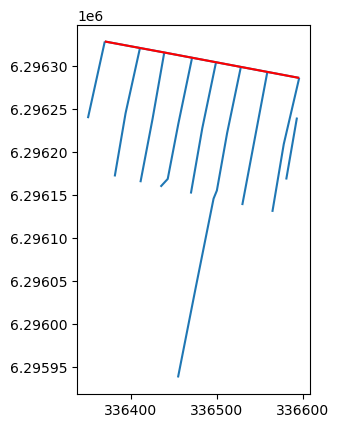

In [38]:
fig,ax = plt.subplots()
qgis_snapping_test.loc[qgis_snapping_test['IDcllbf']==30262].plot(ax=ax,zorder=2,color='red')
qgis_snapping_test.plot(ax=ax,zorder=1)

In [46]:
qgis_snapping_test.loc[qgis_snapping_test['IDcllbf']==30262]['geometry'].unique()

<GeometryArray>
[<LINESTRING (336369.749 6296328.592, 336438.898 6296315.788, 336595.808 6296...>]
Length: 1, dtype: geometry

In [47]:
qgis_snapping_test['geometry']

15650    LINESTRING (336580.701 6296168.053, 336593.202...
30261    LINESTRING (336369.749 6296328.592, 336438.898...
30970    LINESTRING (336558.760 6296293.203, 336529.592...
30971    LINESTRING (336434.546 6296159.667, 336442.924...
30974    LINESTRING (336411.197 6296164.906, 336425.339...
30975    LINESTRING (336469.832 6296151.750, 336483.106...
30977    LINESTRING (336454.848 6295937.878, 336475.395...
30983    LINESTRING (336381.293 6296171.616, 336393.874...
30984    LINESTRING (336369.749 6296328.592, 336350.111...
30986    LINESTRING (336564.596 6296130.428, 336577.862...
Name: geometry, dtype: geometry

In [45]:
test = qgis_snapping_test['geometry'].snap(, tolerance=1)

AttributeError: 'GeoSeries' object has no attribute 'snap'

### geopandas snap test

In [63]:
#https://geopandas.org/en/v1.0.1/docs/reference/api/geopandas.GeoSeries.snap.html
from shapely import Polygon, LineString, Point
s = gpd.GeoSeries([Point(0.5, 2.5),LineString([(0.1, 0.1), (0.49, 0.51), (1.01, 0.89)]),
                   #Polygon([(0, 0), (0, 10), (10, 10), (10, 0), (0, 0)]),
                  ],)
s2 = gpd.GeoSeries([Point(0, 2),LineString([(0, 0), (0.5, 0.5), (1.0, 1.0)])],index=range(1, 3),)

<Axes: >

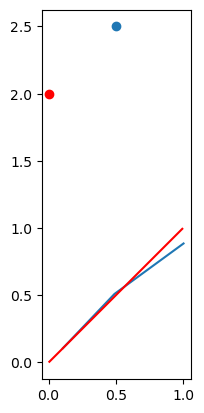

In [64]:
fig,ax = plt.subplots()
s.plot(ax=ax)
s2.plot(ax=ax,color='red')

In [65]:
s.snap(Point(0, 2), tolerance=1)

AttributeError: 'GeoSeries' object has no attribute 'snap'

### pygeos snap test

In [85]:
# https://gis.stackexchange.com/questions/377552/python-geopandas-fill-small-gaps-between-linestrings-in-a-graph-to-get-only-one
import pygeos

def close_gaps(df, tolerance):
    """Close gaps in LineString geometry where it should be contiguous.
    Snaps both lines to a centroid of a gap in between.
    """
    geom = df.geometry.values.data
    coords = pygeos.get_coordinates(geom)
    indices = pygeos.get_num_coordinates(geom)

    # generate a list of start and end coordinates and create point geometries
    edges = [0]
    i = 0
    for ind in indices:
        ix = i + ind
        edges.append(ix - 1)
        edges.append(ix)
        i = ix
    edges = edges[:-1]
    points = pygeos.points(np.unique(coords[edges], axis=0))

    buffered = pygeos.buffer(points, tolerance)

    dissolved = pygeos.union_all(buffered)

    exploded = [
        pygeos.get_geometry(dissolved, i)
        for i in range(pygeos.get_num_geometries(dissolved))
    ]

    centroids = pygeos.centroid(exploded)

    snapped = pygeos.snap(geom, pygeos.union_all(centroids), tolerance)

    return snapped

df = qgis_snapping_test[0:1]
snapped_df = close_gaps(df, 1)

/tmp/ipykernel_3692/1392337257.py:8: DeprecationWarning: Accessing the underlying geometries through the `.data` attribute is deprecated and will be removed in GeoPandas 1.0. You can use `np.asarray(..)` or the `to_numpy()` method instead.
Note that if you are using PyGEOS and using this attribute to get an array of PyGEOS geometries, those other methods will always return an array of Shapely geometries. Accessing the underlying PyGEOS geometries directly is deprecated, and you should migrate to use Shapely >= 2.0 instead.
  geom = df.geometry.values.data


TypeError: One of the arguments is of incorrect type. Please provide only Geometry objects.